In [1]:
from src.config import data_path
#from sklearn.preprocessing import OneHotEncoder
from pyproj import Geod
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
#import torch

# Read data
df_raw = pd.read_csv(data_path, encoding='cp1252')

## Data cleaning

In [3]:
# Fix data entry error; mismatched June labels
df_raw['Month'] = df_raw['Month'].str.replace('June ', 'June')

# Select only relevant columns
# Hill = number of plants sampled
# w/PM = "with powdery mildew"
data = df_raw[['Year', 'Month', 'Centroid Lat', 'Centroid Long', 'Area_Acres', 'Susceptibility to R6 Strains', 
          'Susceptibility to non-R6 Strains', 'Hill', 'w/PM', 'Initial Strain', 'Monthly Sprays']]
wind_data_raw = df_raw.iloc[:,-32:]
data = pd.concat([data, wind_data_raw], axis=1)

# Column labels
cols = data.columns.tolist()

# Remove rows with values of '.' in wind data columns; these are missing values
for i in range(len(cols) - 32, len(cols)):
    data = data[data[cols[i]] != '.']

# Remove rows with missing values in lat/long columns
data = data[data['Centroid Lat'] != '.']

# Remove rows with missing values in Hill column and convert to float
data = data[data['Hill'] != '.']
data = data.astype({'Hill': 'float64'})

# Remove rows with missing values in Monthly Sprays column and convert to float
data = data[data['Monthly Sprays'] != '.']
data = data.astype({'Monthly Sprays': 'float64'})

# Fix data entry error; misclassified UNKNOWN as '.'
data['w/PM'] = data['w/PM'].astype(float)
data.loc[((data['Initial Strain'] == '.') & (data['w/PM'] > 0)), 'Initial Strain'] = 'UNKNOWN'

# Convert values of '.' and 'non-R6' in initial strain column to 0
data.loc[(data['Initial Strain'] == '.') | (data['Initial Strain'] == 'non-R6'), 'Initial Strain'] = 0

# Convert values of ''UNKNOWN' and 'R6' in initial strain column to 1
data.loc[(data['Initial Strain'] == 'UNKNOWN') | (data['Initial Strain'] == 'R6'), 'Initial Strain'] = 1

# Remove duplicate data entry error for variety 'Simcoe' in April 2017
data.drop(1572, inplace=True)

# Convert values of 'Susceptibility to R6/non-R6 Strains' to 1 if > 0
data['Susceptibility to R6 Strains'] = (data['Susceptibility to R6 Strains'] > 0).astype(int)
data['Susceptibility to non-R6 Strains'] = (data['Susceptibility to non-R6 Strains'] > 0).astype(int)

# Remove rows for which 'Susceptibility to R6 Strains' and 'Susceptibility to non-R6 Strains' are both equal to 0
data = data[~((data['Susceptibility to R6 Strains'] == 0) & (data['Susceptibility to non-R6 Strains'] == 0))]

# Convert data type to float
data.iloc[:, -32:] = data.iloc[:, -32:].astype(float)
data[['Centroid Lat', 'Centroid Long']] = data[['Centroid Lat', 'Centroid Long']].astype(float)

# Identify unique months
unique_months = data['Month'].unique()

# Identify unique years
unique_years = data['Year'].unique()

# Sort data by 'Centroid Lat'
data.sort_values(by='Centroid Lat', inplace=True)

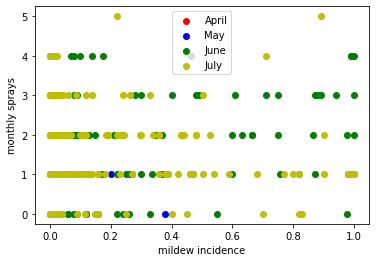

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure
from ipywidgets import interactive

mildew_incidence_april = np.array(data.loc[data['Month'] == 'April', 'w/PM']) / np.array(data.loc[data['Month'] == 'April', 'Hill'])
monthly_sprays_april = np.array(data.loc[data['Month'] == 'April', 'Monthly Sprays'])

mildew_incidence_may = np.array(data.loc[data['Month'] == 'May', 'w/PM']) / np.array(data.loc[data['Month'] == 'May', 'Hill'])
monthly_sprays_may = np.array(data.loc[data['Month'] == 'May', 'Monthly Sprays'])

mildew_incidence_june = np.array(data.loc[data['Month'] == 'June', 'w/PM']) / np.array(data.loc[data['Month'] == 'June', 'Hill'])
monthly_sprays_june = np.array(data.loc[data['Month'] == 'June', 'Monthly Sprays'])

mildew_incidence_july = np.array(data.loc[data['Month'] == 'July', 'w/PM']) / np.array(data.loc[data['Month'] == 'July', 'Hill'])
monthly_sprays_july = np.array(data.loc[data['Month'] == 'July', 'Monthly Sprays'])

plt.scatter(mildew_incidence_april, monthly_sprays_april, color='r', label='April')
plt.scatter(mildew_incidence_may, monthly_sprays_may, color='b', label='May')
plt.scatter(mildew_incidence_june, monthly_sprays_june, color='g', label='June')
plt.scatter(mildew_incidence_july, monthly_sprays_july, color='y', label='July')
plt.xlabel("mildew incidence")
plt.ylabel("monthly sprays")
plt.legend()
plt.show()

In [28]:
def f(month=0):
   
    figure(figsize=(6, 4.5), dpi=100)
   
    if month == 0:
       
        plt.scatter(mildew_incidence_april, monthly_sprays_april, color='r', label='April')
        plt.xlabel("mildew incidence")
        plt.ylabel("monthly sprays")
        plt.title("April")
        #plt.show()
    
    elif month == 1:
       
        plt.scatter(mildew_incidence_may, monthly_sprays_may, color='b', label='May')
        plt.xlabel("mildew incidence")
        plt.ylabel("monthly sprays")
        plt.title("May")
        #plt.show()
        
    elif month == 2:
       
        plt.scatter(mildew_incidence_june, monthly_sprays_june, color='g', label='June')
        plt.xlabel("mildew incidence")
        plt.ylabel("monthly sprays")
        plt.title("June")
        #plt.show()
        
    elif month == 3:
       
        plt.scatter(mildew_incidence_july, monthly_sprays_july, color='y', label='July')
        plt.xlabel("mildew incidence")
        plt.ylabel("monthly sprays")
        plt.title("July")
        #plt.show()

    
interactive_plot = interactive(f, month=(0, 3, 1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=0, description='month', max=3), Output()), _dom_classes=('widget-interac…

In [3]:
# Function to create a tensor of all unique combinations of year and month
def tensor(data):
    '''for each unique month and year, create a tensor of data
    '''
    tensor = []
    for year in unique_years:
        for month in unique_months:
            data_month = data[(data['Year'] == year) & (data['Month'] == month)]
            data_month = data_month.drop(['Year', 'Month'], axis=1)
            data_month.sort_values(by=['Centroid Lat', 'Centroid Long'], inplace=True)
            data_month = data_month.values
            tensor.append(data_month)
    return tensor


# Create data[t][m][N_t_m][k] which is a tensor of shape t x m x N_t_m x k where, 
# t = 0,...,3 corresponding to the 4 years of data,
# m = 0,...,3 corresponding to the 4 months of data,
# N_t_m is the number of yards sampled which varies with year t and month m,
# k = 0,...,39 is the 41 features.
data = np.array(tensor(data), dtype=object)
data = data.reshape(len(unique_years), len(unique_months))

## Array containing number of yards

Number of yards for year i and month j

In [4]:
# Create array N_j[i][j] containing number of yards in month j of year i
N_j = np.zeros((len(unique_years), len(unique_months)))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        N_j[i][j] = len(data[i][j])
N_j = np.int32(N_j)

# Define max_N_j as the maximum number of yards in any month of any year
max_N_j = np.max(N_j)

In [5]:
# Create data_j with dim = (4, 4, 135, 41), padding uneven number of yards with 0's
data_j = np.zeros((len(unique_years), len(unique_months), max_N_j, 41))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        data_j[i][j] = np.pad(data[i][j], ((0, max_N_j - len(data[i][j])), (0, 0)), 'constant', constant_values=0)

## Fix mismatch in lagged data

In [6]:
# Function to identify rows where yards are mismatched between yards in current month and previous month
def identify_mismatch_yards(year, month):
    
    t = year
    m = month
    N_t_m = N_j[t][m]
    N_t_m_lag = N_j[t][m-1]
    
    # Yard locations in current month
    yd_loc = data_j[t, m, 0:max_N_j, 0:2]
    
    # Yard locations in previous month
    yd_loc_lag = data_j[t, m-1, 0:max_N_j, 0:2]
    
    mismatched = []
    
    # Find rows with mismatched yard locations between current and previous month
    if N_t_m < N_t_m_lag:
        
        logical_test = np.isin(np.sum(yd_loc_lag, axis=1), np.sum(yd_loc, axis=1), invert=True)
        mismatched_rows = np.where(logical_test)[0]
        mismatched.append(mismatched_rows.tolist())

        # Remove mismatched rows from previous month
        yd_loc_lag = np.delete(yd_loc_lag, mismatched_rows, axis=0)
        yd_loc_lag = np.pad(yd_loc_lag, ((0, max_N_j - len(yd_loc_lag)), (0, 0)), 'constant', constant_values=0.0)
        
    elif N_t_m > N_t_m_lag:
        logical_test = np.isin(np.sum(yd_loc, axis=1), np.sum(yd_loc_lag, axis=1), invert=True)
        mismatched_rows = np.where(logical_test)[0]
        mismatched.append(mismatched_rows.tolist())
        
        # Remove mismatched rows from current month
        yd_loc = np.delete(yd_loc, mismatched_rows, axis=0)
        yd_loc = np.pad(yd_loc, ((0, max_N_j - len(yd_loc)), (0, 0)), 'constant', constant_values=0.0)


    if ((yd_loc_lag[:,0] == yd_loc[:,0]) & (yd_loc_lag[:,1] == yd_loc[:,1])).all() == False:
    
        if N_t_m > N_t_m_lag:
        
            logical_test = np.isin(np.sum(yd_loc_lag, axis=1), np.sum(yd_loc, axis=1), invert=True)
            mismatched_rows = np.where(logical_test)[0]
            mismatched.append(mismatched_rows.tolist())
            
            # Remove mismatched rows from previous month
            yd_loc_lag = np.delete(yd_loc_lag, mismatched_rows, axis=0)
            yd_loc_lag = np.pad(yd_loc_lag, ((0, max_N_j - len(yd_loc_lag)), (0, 0)), 'constant', constant_values=0.0)
        
        elif N_t_m < N_t_m_lag:
            logical_test = np.isin(np.sum(yd_loc, axis=1), np.sum(yd_loc_lag, axis=1), invert=True)
            mismatched_rows = np.where(logical_test)[0]
            mismatched.append(mismatched_rows.tolist())
            
            # Remove mismatched rows from current month
            yd_loc = np.delete(yd_loc, mismatched_rows, axis=0)
            yd_loc = np.pad(yd_loc, ((0, max_N_j - len(yd_loc)), (0, 0)), 'constant', constant_values=0.0)
    
    return mismatched

Previously, N_j = M = array([[105, 102, 105, 105],
                             [122, 122, 122, 122],
                             [124, 124, 124, 124],
                             [134, 135, 132, 132]])


After removing varieties with no susceptibility:

In [7]:
M = N_j

print(M)

[[100  97 100 100]
 [114 114 114 114]
 [116 116 116 116]
 [125 126 124 124]]


In [8]:
# Number of rows dropped after removing varieties with no susceptibility

print(np.array([[105, 102, 102, 105],
              [122, 122, 122, 122],
              [124, 124, 124, 124],
              [134, 131, 131, 132]]) - N_j)

[[5 5 2 5]
 [8 8 8 8]
 [8 8 8 8]
 [9 5 7 8]]


In [9]:
# N[t,m] is the Total number of yards i in month m of year t

num_mismatch = np.array([[0, 0, 3, 0],
                         [0, 0, 0, 0],
                         [0, 0, 0, 0],
                         [0, 3, 1, 0]])


N = N_j - num_mismatch

print(N)

[[100  97  97 100]
 [114 114 114 114]
 [116 116 116 116]
 [125 123 123 124]]


In [10]:
logic_test = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        logic_test[i, j] = np.sum(data_j[i, j, 0:135, 0:2] != data_j[i, j-1, 0:135, 0:2]) / 2
        
print('number of mismatched rows: \n', logic_test)

number of mismatched rows: 
 [[  0.   95.   95.    0. ]
 [  0.    0.    0.    0. ]
 [  0.    0.    0.    0. ]
 [ 64.5  74.  109.5   0. ]]


In [11]:
identify_mismatch_yards(3, 2)

[[10, 14, 96], [23]]

In [12]:
list(range(N[0, 2], N[0, 2] + len(identify_mismatch_yards(0, 2)[0])))

[97, 98, 99]

In [13]:
identify_mismatch_yards(0, 2)[0]

[3, 7, 72]

In [14]:
# Create dataset with dim = (4, 4, 126, 41), padding uneven number of yards with 0's which fixes the mismatched yards 
# and moves them to the bottom of the dataset
dataset = np.zeros((len(unique_years), len(unique_months), max_N_j, 41))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        dataset[i][j] = np.pad(data[i][j], ((0, max_N_j - len(data[i][j])), (0, 0)), 'constant', constant_values=0)

array1_removed = dataset[0, 2, identify_mismatch_yards(0, 2)[0]]

array1 = np.delete(dataset[0, 2], identify_mismatch_yards(0, 2)[0], axis=0)
dataset[0, 2] = np.pad(array1, ((0, max_N_j - len(array1)), (0, 0)), 'constant', constant_values=0)


# Add removed data to bottom of dataset
dataset[0, 2, [97, 98, 99]] = array1_removed


array1 = np.delete(dataset[0, 3], identify_mismatch_yards(0, 2)[0], axis=0)
dataset[0, 3] = np.pad(array1, ((0, max_N_j - len(array1)), (0, 0)), 'constant', constant_values=0)
dataset[0, 3, [97, 98, 99]] = array1_removed


array1_removed = dataset[3, 1, [10, 14, 96]]

array1 = np.delete(dataset[3, 1], [10, 14, 96], axis=0)
dataset[3, 1] = np.pad(array1, ((0, max_N_j - len(array1)), (0, 0)), 'constant', constant_values=0)

# Add removed data to bottom of dataset
dataset[3, 1, [123, 124, 125]] = array1_removed


array1_removed = dataset[3, 2, 23]

array1 = np.delete(dataset[3, 2], [23], axis=0)
dataset[3, 2] = np.pad(array1, ((0, max_N_j - len(array1)), (0, 0)), 'constant', constant_values=0)

# Add removed data to bottom of dataset
dataset[3, 2, 123] = array1_removed

array1 = np.delete(dataset[3, 3], [23], axis=0)
dataset[3, 3] = np.pad(array1, ((0, max_N_j - len(array1)), (0, 0)), 'constant', constant_values=0)
dataset[3, 3, 123] = array1_removed

# Test how many mismatched rows are in each year for may/june, result should be:
# [[ 95.  95.   3.   0.]
# [  0.   0.   0.   0.]
# [  0.   0.   0.   0.]
# [110. 111.   3.   0.]]

logic_test = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        logic_test[i, j] = np.sum(dataset[i, j, 0:135, 0:2] != dataset[i, j-1, 0:135, 0:2]) / 2
        
print('number of mismatched rows: \n', logic_test)

number of mismatched rows: 
 [[ 95.  95.   3.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [110. 111.   3.   0.]]


## Plants sampled, diseased counts and area

In [15]:
# Create n_y[i][j][k] containing the number of plants sampled in year i, month j, and yard k
n_y = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(N[i][j]):

                n_y[i][j][k] = dataset[i][j][k][5]
                
                
# Create y[i][j][k] containing the number of diseased plants found in year i, month j, and yard k
y = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(N[i][j]):

                y[i][j][k] = dataset[i][j][k][6]


# Create n_z[i][j][k] containing the number of plants sampled in year i, month j, and yard k
n_z = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(len(data[i][j])):

                n_z[i][j][k] = dataset[i][j][k][5]


# Create z[i][j][k] containing the number of diseased plants found in year i, month j, and yard k
z = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(len(dataset[i][j])):

                z[i][j][k] = dataset[i][j][k][6]
                
# Create area[i][j][k] containing the area of yard k in year i and month j
area = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(len(data[i][j])):

                # Convert area from acres to hectares
                area[i][j][k] = dataset[i][j][k][2] * 0.4046862669715303
                
                
# Create s_j[i][j][k] containing the fungicide spray amount for yard k in year i and month j
s_j = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(len(data[i][j])):

                s_j[i][j][k] = dataset[i][j][k][8]
                
                
# Create s_i[i][j][k] containing the fungicide spray amount for yard k in year i and month j
s_i = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(N[i][j]):

                s_i[i][j][k] = dataset[i][j][k][8]

In [16]:
dataset.shape

(4, 4, 126, 41)

## Wind Data

Need to select wind data by year and month then compute projections.

data[0][0][:,-32:] will select wind data for April 2014

In [17]:
# Create tensor for raw wind data
wind_data = np.array([[dataset[0][0][:, -32:], dataset[0][1][:,-32:], dataset[0][2][:,-32:], dataset[0][3][:,-32:]],
                      [dataset[1][0][:, -32:], dataset[1][1][:,-32:], dataset[1][2][:,-32:], dataset[1][3][:,-32:]],
                      [dataset[2][0][:, -32:], dataset[2][1][:,-32:], dataset[2][2][:,-32:], dataset[2][3][:,-32:]],
                      [dataset[3][0][:, -32:], dataset[3][1][:,-32:], dataset[3][2][:,-32:], dataset[3][3][:,-32:]]], dtype=object)

# Create tensor for wind speed
wind_speed = np.array([[dataset[0][0][:, -32:][:,::2], dataset[0][1][:,-32:][:,::2], dataset[0][2][:,-32:][:,::2], dataset[0][3][:,-32:][:,::2]],
                        [dataset[1][0][:, -32:][:,::2], dataset[1][1][:,-32:][:,::2], dataset[1][2][:,-32:][:,::2], dataset[1][3][:,-32:][:,::2]],
                        [dataset[2][0][:, -32:][:,::2], dataset[2][1][:,-32:][:,::2], dataset[2][2][:,-32:][:,::2], dataset[2][3][:,-32:][:,::2]],
                        [dataset[3][0][:, -32:][:,::2], dataset[3][1][:,-32:][:,::2], dataset[3][2][:,-32:][:,::2], dataset[3][3][:,-32:][:,::2]]], dtype=object)

# Create tensor for wind percent time
wind_percent_time = np.array([[dataset[0][0][:, -32:][:,1::2], dataset[0][1][:,-32:][:,1::2], dataset[0][2][:,-32:][:,1::2], dataset[0][3][:,-32:][:,1::2]],
                        [dataset[1][0][:, -32:][:,1::2], dataset[1][1][:,-32:][:,1::2], dataset[1][2][:,-32:][:,1::2], dataset[1][3][:,-32:][:,1::2]],
                        [dataset[2][0][:, -32:][:,1::2], dataset[2][1][:,-32:][:,1::2], dataset[2][2][:,-32:][:,1::2], dataset[2][3][:,-32:][:,1::2]],
                        [dataset[3][0][:, -32:][:,1::2], dataset[3][1][:,-32:][:,1::2], dataset[3][2][:,-32:][:,1::2], dataset[3][3][:,-32:][:,1::2]]], dtype=object)
 
# Compute wind_run[i][j][k][l] where i is the year, j is the month, 
# k is the yard from which wind originates,
# l = 0,...,15 is the wind run corresponding to each cardinal direction
wind_run = wind_speed * wind_percent_time

# Convert from mi/hr to km/s
wind_run = wind_run * 0.44704 * 0.001                          

In [18]:
# Function to convert bearing to angle in standard form
def standard_form(angle):
    
    theta = np.pi / 2 - angle
    theta = np.where(theta < 0, theta + 2 * np.pi, theta)
    theta = np.where(theta > 2 * np.pi, theta - 2 * np.pi, theta)
    
    return theta

# Function to convert convert angle to angle between 0 and 2pi
def coterminal(angle):
    
    theta = np.where(angle < 0, angle + 2 * np.pi, angle)
    theta = np.where(theta > 2 * np.pi, theta - 2 * np.pi, theta)
    
    return theta

In [19]:
# Cardinal direction labels
cardinal_directions = np.array(['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'])

# Define 16 cardinal angles in radians
cardinal_angles = np.linspace(0, 2 * np.pi, 17)
cardinal_angles = cardinal_angles[:-1]

# Convert bearing to angles in standard form
cardinal_angles = standard_form(cardinal_angles)

## Distance and bearing tensors

In [20]:
wgs84_geod = Geod(ellps='WGS84')

# Create bearing_tensor[i][j][k][l] containing the geodesic bearing between the great circles
# from yard k to yard l
# for year i and month j
bearing_tensor = []

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        bearing_matrix = np.zeros((N[i][j], len(data[i][j])))
        bearing_tensor.append(bearing_matrix)
        
bearing_tensor = np.array(bearing_tensor, dtype=object)
bearing_tensor = bearing_tensor.reshape(len(unique_years), len(unique_months))

# Create distance[i][j][k][l] containing geodesic distance between yard k and yard l
# for year i and month j
distance = np.zeros((len(unique_years), len(unique_years), max_N_j, max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(N[i][j]):
            for l in range(len(data[i][j])):
                latK = dataset[i][j][k][0]
                longK = dataset[i][j][k][1]
    
                latL = dataset[i][j][l][0]
                longL = dataset[i][j][l][1]
    
                azKL, azLK, dist = wgs84_geod.inv(longK, latK, longL, latL)
                
                # Compute distance in km between yards k and l
                distance[i][j][k][l] = dist * 0.001
                
                # Convert azimuth to standard form
                azKL = standard_form(azKL * np.pi / 180)
                
                # Compute geodesic bearing from yard k to yard l
                if k == l:
                    bearing_tensor[i][j][k][l] = np.nan
                else:
                    bearing_tensor[i][j][k][l] = azKL
                

## Wind tensor

In [21]:
# Create wind[i][j][k][l] containing mean of scalar projections of wind run
# where i is the year, j is the month
# k is the yard from which wind originates and l is the destination yard

wind = np.zeros((len(unique_years), len(unique_years), max_N_j, max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(N[i][j]):
            for l in range(len(data[i][j])):

                # Define bounds within +/- 90 degrees of the bearing from yard i to yard j
                bounds = np.array([bearing_tensor[i][j][k][l] - np.pi / 2, bearing_tensor[i][j][k][l] + np.pi / 2])
                lower_bound = coterminal(min(bounds))
                upper_bound = coterminal(max(bounds))
                
                # Select cardinal directions within bounds
                cardinal_index = np.where(lower_bound < upper_bound, (lower_bound < cardinal_angles) & (cardinal_angles < upper_bound), (lower_bound < cardinal_angles) | (cardinal_angles < upper_bound))
                cardinal_index_num = np.where(cardinal_index)
                cardinal_index_num = cardinal_index_num[0]
                
                if len(cardinal_index_num) == 0:
                    cardinal_index_num = [0] * 8
                    
                # Compute bearing vector by first converting bearing to angles in standard position
                bearing_vector = np.array([np.cos(bearing_tensor[i][j][k][l]), np.sin(bearing_tensor[i][j][k][l])])
                
                # Select cardinal angles within bounds and convert to angles in standard position
                theta = cardinal_angles[cardinal_index]
                if len(theta) == 0:
                    theta = [np.nan] * 8
                
                scalar_proj_list = np.zeros((8, 1))
                for m in range(len(theta)):
            
                    # Compute wind vector
                    wind_vector = wind_run[i][j][k][cardinal_index_num[m]] * np.array([np.cos(theta[m]), np.sin(theta[m])])
                    wind_vector = wind_vector.T
                
                    # Compute scalar projection of wind_vector onto bearing_vector
                    scalar_proj = np.dot(wind_vector, bearing_vector) / np.linalg.norm(bearing_vector)
                    scalar_proj_list[m] = scalar_proj
                
                # Compute mean of scalar projections    
                if k == l:
                    wind[i][j][k][l] = 0.0
                else:
                    wind[i][j][k][l] = np.sum(scalar_proj_list) / len(scalar_proj_list)

## Indicatior functions

In [22]:
# Create sI1[i][j][k] containing the indicator on whether yard k is affected by an R6-virulent race in year i and month j
sI1 = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(len(data[i][j])):

                sI1[i][j][k] = dataset[i][j][k][7]
                

# Create sI2[i][j][k] containing the constant array of 1 for yard k in year i and month j
sI2 = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(len(data[i][j])):

                sI2[i][j][k] = 1
                
                
# Create tI1[i][j][k] containing the indicator on whether yard k is only susceptible to R6-virulent race in year i and month j
tI1 = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(N[i][j]):

                if ((dataset[i][j][k][3] == 1) & (dataset[i][j][k][4] == 0)):
                    tI1[i][j][k] = 1
                else:
                    tI1[i][j][k] = 0
                    
                    
# Create tI2[i][j][k] containing the indicator on whether yard k is susceptible to both races in year i and month j
tI2 = np.zeros((len(unique_years), len(unique_years), max_N_j))

for i in range(len(unique_years)):    
    for j in range(len(unique_months)):
        for k in range(N[i][j]):

                if ((dataset[i][j][k][3] == 1) & (dataset[i][j][k][4] == 1)):
                    tI2[i][j][k] = 1
                else:
                    tI2[i][j][k] = 0

## Combine all years for wind and distance

In [23]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

In [24]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

In [25]:
logic_test

array([[ 95.,  95.,   3.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [110., 111.,   3.,   0.]])

In [26]:
num_mismatch

array([[0, 0, 3, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 3, 1, 0]])

In [27]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

In [28]:
dataset[0][1].shape

(126, 41)

In [29]:
dataset0 = dataset[0]

In [30]:
dataset0.shape

(4, 126, 41)

In [31]:
dataset0[:,0].shape

(4, 41)

In [32]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

In [36]:
selected_rows = list(range(0, 100))
selected_rows.append(list(range(100, 200)))

dataset0 = np.swapaxes(dataset[0, 2:4, 0:100],0,1)
dataset1 = np.swapaxes(dataset[1, 2:4, 0:114],0,1)
dataset2 = np.swapaxes(dataset[2, 2:4, 0:116],0,1)
dataset3 = np.swapaxes(dataset[3, 2:4, 0:124],0,1)

dataset_JJ = np.vstack((dataset0, dataset1, dataset2, dataset3)) # stack the data vertically
dataset_JJ = np.swapaxes(dataset_JJ,0,1)

print(dataset_JJ.shape)

(2, 454, 41)


In [37]:
m = 3

# Number of yards i for each month in all years
N_all = np.int32(np.sum(N, axis=0))

# Number of yards j for each month in all years
M_all = np.int32(np.sum(M, axis=0))

In [38]:
M_all

array([455, 453, 454, 454])

In [ ]:
def array_join(input_arr, m=3):

    arr1 = input_arr[0, m, 0:N[0, m]].reshape(N[0, m], 1)
    arr2 = input_arr[1, m, 0:N[1, m]].reshape(N[1, m], 1)  
    arr3 = input_arr[2, m, 0:N[2, m]].reshape(N[2, m], 1)
    arr4 = input_arr[3, m, 0:N[3, m]].reshape(N[3, m], 1)
    arr5 = input_arr[0, m, N[0, m]:M[0, m]].reshape(3, 1)
    arr6 = input_arr[3, m, N[3, m]:M[3, m]].reshape(1, 1)
    
    arr = np.vstack((arr1, arr2, arr3, arr4, arr5, arr6))
    
    return arr

In [ ]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

In [ ]:
N

array([[100,  97,  97, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 123, 123, 124]])

In [ ]:
bearing_tensor[0][2].shape

(97, 100)

In [ ]:
# Create bearing_tensor_all[j][k][l] containing the geodesic bearing between the great circles
# from yard k to yard l
# in month j for all years
bearing_tensor_all = np.zeros((len(unique_months), max(N_all), max(N_all)))

# Create distance_all[j][k][l] containing geodesic distance between yard k and yard l
# in month j for all years
distance_all = np.zeros((len(unique_months), max(N_all), max(N_all)))
    
for i in range(len(unique_years)):
    for j in range(len(unique_months)):
        for k in range(N[i][j]):
            for l in range(M[i][j]):
                latK = dataset[i][j][k][0]
                longK = dataset[i][j][k][1]
    
                latL = dataset[i][j][l][0]
                longL = dataset[i][j][l][1]
    
                azKL, azLK, dist = wgs84_geod.inv(longK, latK, longL, latL)
                
                # Compute distance in km between yards k and l
                
                if i == 0:
                    distance_all[j, k, l] = dist * 0.001
                
                elif i == 1:
                    distance_all[j, k + N[i-1][j], l + M[i-1][j]] = dist * 0.001
                
                elif i == 2:
                    distance_all[j, k + N[i-1][j] + N[i-2][j], l + M[i-1][j] + M[i-2][j]] = dist * 0.001
                
                elif i == 3:
                    
                    distance_all[j, k + N[i-1][j] + N[i-2][j] + N[i-3][j], l + M[i-1][j] + M[i-2][j] + M[i-3][j]] = dist * 0.001
                
                # Convert azimuth to standard form
                azKL = standard_form(azKL * np.pi / 180)
                
                # Compute geodesic bearing from yard k to yard l
                
                if i == 0:
                    if k == l:
                        bearing_tensor_all[j, k, l] = np.nan
                    else:
                        bearing_tensor_all[j, k, l] = azKL
                
                elif i == 1:
                    if k == l:
                        bearing_tensor_all[j, k + N[i-1][j], l + M[i-1][j]] = np.nan
                    else:
                        bearing_tensor_all[j, k + N[i-1][j], l + M[i-1][j]] = azKL
                
                elif i == 2:
                    if k == l:
                        bearing_tensor_all[j, k + N[i-1][j] + N[i-2][j], l + M[i-1][j] + M[i-2][j]] = np.nan
                    else:
                        bearing_tensor_all[j, k + N[i-1][j] + N[i-2][j], l + M[i-1][j] + M[i-2][j]] = azKL
                
                elif i == 3:
                    if k == l:
                        bearing_tensor_all[j, k + N[i-1][j] + N[i-2][j] + N[i-3][j], l + M[i-1][j] + M[i-2][j] + M[i-3][j]] = np.nan
                    else:
                        bearing_tensor_all[j, k + N[i-1][j] + N[i-2][j] + N[i-3][j], l + M[i-1][j] + M[i-2][j] + M[i-3][j]] = azKL

In [ ]:
distance[0, 0, 0:N[0,0], 0:M[0,0]].shape

(100, 100)

In [ ]:
N

array([[100,  97,  97, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 123, 123, 124]])

In [ ]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

In [ ]:
distance_all[1]

array([[0.        , 0.18668764, 0.47721685, ..., 0.        , 0.        ,
        0.        ],
       [0.18668764, 0.        , 0.35597234, ..., 0.        , 0.        ,
        0.        ],
       [0.47721685, 0.35597234, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
distance[0, 0, 0][0:N[0,0]]

array([ 0.        ,  0.18668764,  0.47721685,  0.61309266,  0.72728236,
        0.91354078,  0.73364226,  0.91248603,  0.85643618,  0.91996011,
        1.56227988,  1.3362237 ,  1.49482923,  1.17244305,  1.34550392,
        1.31063614,  1.34802241,  1.36876642,  2.49554163,  2.48785048,
        3.13804852,  1.56975859,  2.46388372,  2.14942414,  2.05822669,
        2.02849084,  2.00161558,  2.03877618,  3.47773079,  2.4276104 ,
        2.36015319,  2.30908071,  2.29142425,  2.33727646,  2.31536708,
        2.26657504,  6.26037718,  6.23027639,  6.24615696,  6.41236011,
        7.24845358,  7.32981641,  6.83512428,  6.57906011,  6.77910017,
        7.47964516,  6.99485285,  6.96269126,  6.96896278,  6.99069749,
        7.66166273,  7.61508261,  7.68201071,  7.99243246,  8.06829145,
        8.07115413, 12.22999393, 11.41824642, 12.53252654, 12.34627746,
       12.32650775, 12.39167309, 11.69879731, 12.29869142, 12.00182879,
       11.84294506, 12.18899176, 18.38237244, 18.13978841, 18.54

In [ ]:
distance_all[month, yard, 100:214]

NameError: name 'yard' is not defined

In [ ]:
month = 0
yard = 0

distance[1, month, yard, 0:N[1,month]] == distance_all[month, yard, 100:214]

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
(distance_all[0, 0:N[0,0], 0:M[0,0]] == distance[0, 0, 0:N[0,0], 0:M[0,0]]).all()

True

In [ ]:
N

array([[100,  97,  97, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 123, 123, 124]])

In [ ]:
100+97+97+100

394

In [ ]:
100+114+116+125

455

In [ ]:
97+114+116+123

450

In [ ]:
114+114+114+114

456

In [ ]:
M

array([[100,  97, 100, 100],
       [114, 114, 114, 114],
       [116, 116, 116, 116],
       [125, 126, 124, 124]])

In [ ]:
dataset[3][0][124][0]

45.201

In [ ]:
i=3, j=0,k=0,l=79

In [ ]:
3 * N[3][0]

375

In [ ]:
3 * M[3, 0] + 79

454

## Export data

In [ ]:
#np.savez('../data/processed/data_tensor', N=N, M=M, y=y, z=z, n_y=n_y, n_z=n_z, area=area, wind=wind, distance=distance, sI1=sI1, sI2=sI2, tI1=tI1, tI2=tI2, s_i=s_i, s_j=s_j)

In [ ]:
# Use this to import data_tensor.npy
#X = np.load('../data/processed/data_tensor.npz')